In [2]:
%matplotlib inline

import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2

root_name = 'anthony-ginting-beat-kento-momota-anthony-ginting-vs-kento-momota-fo-2019-hlzrivktbyo'

csvfile = open('./data/%s.mp4.predictions.txt' % root_name, 'r')
predictions = pd.read_csv(csvfile, delimiter=' ', header=None, names=['single', 'all'])

csvfile = open('/home/code-base/user_space/shotcut_dist/output.txt')
predictions = pd.read_csv(csvfile, header=None, names=['single'])

In [3]:
import numpy
def smooth(x,window_len=11,window='hanning'):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=numpy.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:  
        w=eval('numpy.'+window+'(window_len)')
    y=numpy.convolve(w/w.sum(),s,mode='same')
    return y[window_len:-window_len+1]

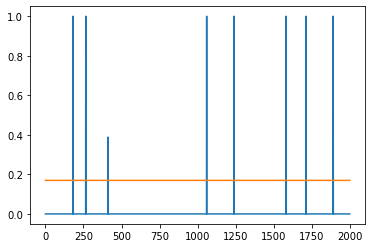

In [4]:
delta = 3
series = predictions['single'].values#smooth(predictions['single'].values, window_len=3, window='hamming')
med = np.mean(series)
std_med = np.mean((series - med)**2)**0.5

L = 2000
thresh = med + delta * std_med
plt.plot(series[:L])
plt.plot([thresh] * L)
plt.show()

In [32]:
cap = cv2.VideoCapture('./data/%s.mp4' % root_name)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # float `width`
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # float `height`
fps = int(cap.get(cv2.CAP_PROP_FPS))

In [ ]:
def visualize_list(coords):
    for fid in coords:
        cap.set(cv2.CAP_PROP_POS_FRAMES, fid)
        ret, frame = cap.read()
        plt.imshow(frame)   
        plt.show()
        
cuts = [0] + np.where(series > thresh)[0].tolist() + [len(series) + 9]

curr_rally, fid = 0, 0
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
outvid = cv2.VideoWriter(
    './output/cuts/rally%d.mp4' % curr_rally, 
    cv2.VideoWriter_fourcc('M','P','4','V'), 
    fps, (width, height)
)

while True:
    ret, frame = cap.read()
    if not ret:
        break    
    outvid.write(frame)
    
    fid += 1
    if fid == cuts[curr_rally + 1]:
        outvid.release()
        curr_rally += 1
        outvid = cv2.VideoWriter(
            './output/cuts/rally%d.mp4' % curr_rally, 
            cv2.VideoWriter_fourcc('M','P','4','V'), 
            fps, (width, height)
        )
outvid.release()

In [13]:
from IPython.display import HTML

HTML(
"""
<video alt="test" controls>
    <source src="./data/%s.mp4">
</video>
""" % root_name
)

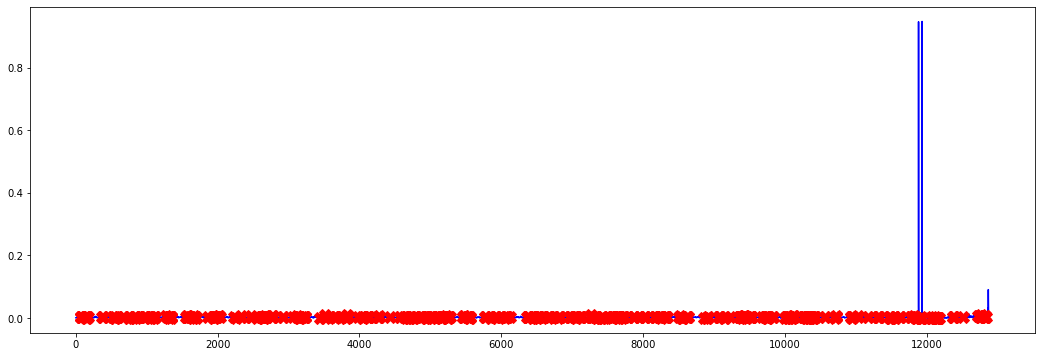

In [18]:
# Some outlier detection programs
from sklearn.ensemble import IsolationForest

outliers_fraction = 0.05
model =  IsolationForest(contamination=outliers_fraction)
model.fit(predictions.values.reshape(-1, 1))
predictions['anomaly'] = pd.Series(model.predict(predictions.values.reshape(-1, 1)))

# visualization
a = predictions.loc[predictions['anomaly'] == -1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(predictions['all'], color='blue', label='Normal')
_ = plt.plot(a['all'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
plt.show()

In [22]:
predictions[:100]

,single,all,anomaly
0,0.000047,0.000641,1
1,0.000060,0.000825,1
2,0.000065,0.000900,1
3,0.000084,0.001061,1
4,0.000089,0.001011,1
...,...,...,...
95,0.000147,0.001708,1
96,0.000168,0.001931,1
97,0.000133,0.001434,1
98,0.000137,0.001433,1
